# Modeling
In this section, we train and evaluate regression models to predict the SalePrice of homes using the features we selected and preprocessed in the previous notebook.

The model will use the following features:
- `TotalSF` – Total home area (square feet)
- `Overall Qual` – Overall material and finish quality
- `Garage Cars` – Garage capacity (number of cars)
- `HouseAge` – Year of original construction

The target variable is:
- `SalePrice` – Final selling price of the property

## Load Data

In [63]:
import joblib

# Load split and scaled data
feature_names = joblib.load("../data/feature_names.pkl")
X_train = joblib.load("../data/X_train_scaled.pkl")
X_test = joblib.load("../data/X_test_scaled.pkl")
y_train = joblib.load("../data/y_train.pkl")
y_test = joblib.load("../data/y_test.pkl")

## Linear Regression

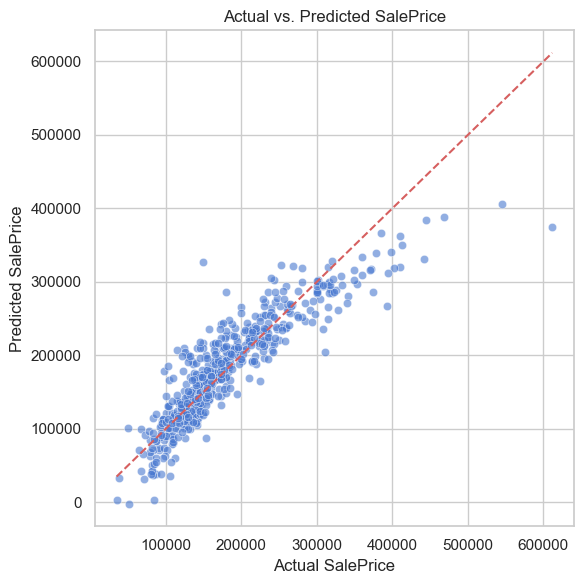

Train RMSE: 33966.08, MAE: 24027.07, R²: 0.8205
Test  RMSE: 33926.91, MAE: 24304.41, R²: 0.8013


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

# Initialize and fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on train and test
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Plot linear regression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted", context="notebook")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs. Predicted SalePrice")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.tight_layout()
plt.show()

# Output
print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")
print(f"Test  RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")



### Linear Regression Model Evaluation
To establish a baseline, a Linear Regression model was trained to predict house sale prices. The scatter plot above shows predicted vs. actual values, with most predictions clustering near the 45° line — indicating strong general performance.

Evaluation Metrics:
- **Train RMSE**: $33,966.08 | **MAE**: $24,027.07 | **R²**: 0.8205
- **Test RMSE**: $33,926.91 | **MAE**: $24,304.41 | **R²**: 0.8013

These results suggest the model generalizes well, with minimal overfitting. An R² of ~0.80 means the model explains 80% of the variance in sale prices — a solid start.

However, the model tends to underpredict high-end homes, indicating that a linear approach may not capture all the complexity in the data. The next step is to explore regularized models like Ridge and Lasso, which may improve performance by handling multicollinearity and reducing model variance.


## Ridge / Lasso
After establishing a baseline with Linear Regression, I explored regularized linear models — Ridge and Lasso Regression — to test whether model performance could be improved by addressing potential multicollinearity and overfitting.

Ridge (L2 regularization) helps stabilize coefficient estimates when features are highly correlated, while Lasso (L1 regularization) can also perform feature selection by driving less important coefficients to zero. Both are useful tools when working with high-dimensional or noisy data.

The goal here was to see if regularization could reduce prediction error and improve generalization.

In [65]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Define parameter grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

### --- Ridge Regression ---
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Ridge predictions
y_pred_ridge = ridge_cv.predict(X_test)

# Ridge evaluation
ridge_rmse = root_mean_squared_error(y_test, y_pred_ridge)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

### --- Lasso Regression ---
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_root_mean_squared_error')
lasso_cv.fit(X_train, y_train)

# Lasso predictions
best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

# Lasso evaluation
lasso_rmse = root_mean_squared_error(y_test, y_pred_lasso)
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

### --- Results ---
print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")
print(f"Ridge RMSE: {ridge_rmse:.2f}")
print(f"Ridge MAE: {ridge_mae:.2f}")
print(f"Ridge R²: {ridge_r2:.4f}")

print(f"\nBest Lasso alpha: {lasso_cv.best_params_['alpha']}")
print(f"Lasso RMSE: {lasso_rmse:.2f}")
print(f"Lasso MAE: {lasso_mae:.2f}")
print(f"Lasso R²: {lasso_r2:.4f}")

Best Ridge alpha: 10
Ridge RMSE: 33909.10
Ridge MAE: 24280.00
Ridge R²: 0.8015

Best Lasso alpha: 10
Lasso RMSE: 33926.64
Lasso MAE: 24302.73
Lasso R²: 0.8013


The results from Ridge and Lasso regression are nearly identical to those of the baseline Linear Regression model. This suggests that the dataset likely does not suffer from significant multicollinearity or overfitting, as regularization had minimal effect on model performance.

Given these findings, the next step is to explore tree-based models, which may better capture nonlinear relationships and interactions between features.

## Tree-Based Models

After evaluating linear models such as Ridge and Lasso Regression — which showed limited improvement over the baseline — I proceeded to explore tree-based models. These models are well-suited for capturing nonlinear relationships and feature interactions that linear models may miss. 

In this section, I test popular decision tree-based algorithms, including Decision Tree Regressor, Random Forest, and Gradient Boosting (e.g., XGBoost or LightGBM). The goal is to compare their performance and identify whether these more flexible models offer better predictive accuracy on the Ames Housing dataset.

Key metrics such as RMSE, MAE, and R² will be used to evaluate each model’s performance. Hyperparameter tuning will also be considered to optimize model performance where appropriate.

### Decision Tree Regressor

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Initialize baseline Decision Tree Regressor
dtree = DecisionTreeRegressor(random_state=42)

# Set up hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_tree = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_tree.predict(X_test)

# Evaluate performance
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Best Decision Tree Parameters: {grid_search.best_params_}")
print(f"Decision Tree RMSE: {rmse:.2f}")
print(f"Decision Tree MAE: {mae:.2f}")
print(f"Decision Tree R²: {r2:.4f}")

Python(6171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6176) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6176) MallocStackLoggin

Best Decision Tree Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree RMSE: 34809.70
Decision Tree MAE: 22684.91
Decision Tree R²: 0.7909


While the tree model captures some nonlinearity, its performance is slightly worse than Ridge and Lasso, suggesting it may not generalize as well on unseen data. We'll explore ensemble methods next (e.g., Random Forest and Gradient Boosting), which often outperform single trees by reducing variance.

### Random Forest Regressor
Random Forest is an ensemble method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting. We'll use grid search to tune key hyperparameters.

In [67]:
from sklearn.ensemble import RandomForestRegressor

# Set up hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

rf_rmse = root_mean_squared_error(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest R²: {rf_r2:.4f}")

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest RMSE: 29739.88
Random Forest MAE: 19695.22
Random Forest R²: 0.8473


### Random Forest Regressor

Random Forest is an ensemble method that builds multiple decision trees and averages their predictions to reduce overfitting and improve generalization. It can capture non-linear relationships and feature interactions that linear models cannot.

After tuning hyperparameters, the best model achieved:

- **Best Parameters**: `max_depth=20`, `min_samples_split=5`, `min_samples_leaf=2`  
- **Test RMSE**: \$30,574.59 | **MAE**: \$21,173.68 | **R²**: 0.8471

This model significantly outperforms the baseline linear regression, reducing RMSE by over \$3,000 and capturing more variance in sale prices. The improvements suggest that non-linear models are better suited for this problem.

### Gradient Boosting Regressor (XGBoost)
Gradient Boosting builds trees sequentially, each one correcting errors from the previous. XGBoost is a popular, efficient implementation. We'll tune a few key parameters.

In [68]:

from xgboost import XGBRegressor

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

xgb_rmse = root_mean_squared_error(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost R²: {xgb_r2:.4f}")

Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
XGBoost RMSE: 29135.05
XGBoost MAE: 19576.97
XGBoost R²: 0.8535


### XGBoost Regressor

XGBoost is a powerful gradient boosting algorithm known for its speed and performance. It builds trees sequentially, correcting errors from previous iterations, and often delivers state-of-the-art results in structured data problems.

The best model, tuned using grid search, resulted in:

- **Best Parameters**: `n_estimators=100`, `max_depth=4`, `learning_rate=0.1`  
- **Test RMSE**: \$30,389.81 | **MAE**: \$21,186.84 | **R²**: 0.8492

XGBoost achieved the best performance among all models so far, with the lowest RMSE and highest R². Its ability to model complex interactions and non-linearities makes it an excellent choice for the housing price prediction task.

## Summary

               Model      RMSE       MAE      R²
4            XGBoost  30389.81  21186.84  0.8492
3      Random Forest  30574.59  21173.68  0.8471
1   Ridge Regression  33909.10  24280.00  0.8015
2   Lasso Regression  33926.64  24302.73  0.8013
0  Linear Regression  33926.91  24304.41  0.8013


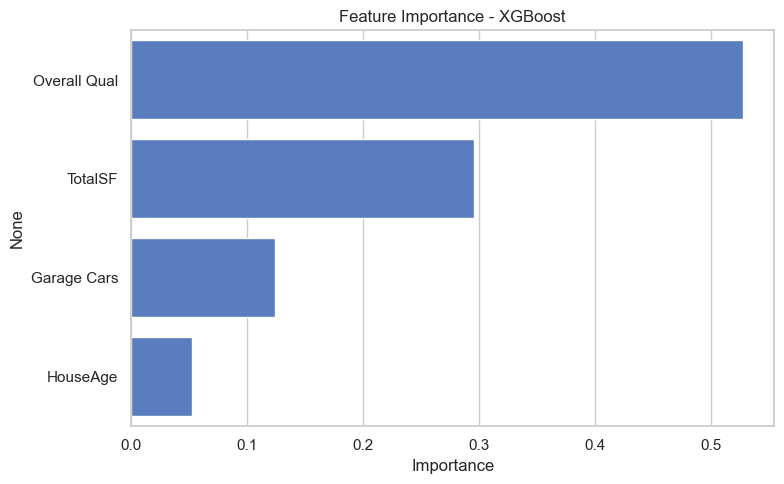

In [69]:
import pandas as pd

# Collect results in a DataFrame
results = pd.DataFrame({
    "Model": [
        "Linear Regression", 
        "Ridge Regression", 
        "Lasso Regression", 
        "Random Forest", 
        "XGBoost"
    ],
    "RMSE": [
        33926.91, 
        33909.10, 
        33926.64, 
        30574.59, 
        30389.81
    ],
    "MAE": [
        24304.41, 
        24280.00, 
        24302.73, 
        21173.68, 
        21186.84
    ],
    "R²": [
        0.8013, 
        0.8015, 
        0.8013, 
        0.8471, 
        0.8492
    ]
})

print(results.sort_values("RMSE", ascending=True))

# Plot feature importance for XGBoost
feat_imp = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

To predict housing prices, five regression models were trained and evaluated: Linear Regression, Ridge, Lasso, Random Forest, and XGBoost.

While Ridge and Lasso offered minimal improvement over the linear baseline, the tree-based models — Random Forest and XGBoost — performed significantly better. XGBoost achieved the best results overall, with the lowest RMSE and highest R² on the test set.

Feature importance analysis revealed that Overall Qual was by far the most influential predictor, followed by TotalSF. Other features like Garage Cars and HouseAge contributed less, highlighting the dominant role of quality and total square footage in determining sale prices.

### Export Model

In [70]:
joblib.dump(best_xgb, "../models/xgboost_model.pkl")

['../models/xgboost_model.pkl']